<a href="https://colab.research.google.com/github/regisalbuquerque/nlp_tests/blob/main/Trabalho_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O primeiro trabalho está relacionado ao tema de Aprendizado de Máquina.
O trabalho pode ser feito em dupla. 

Para o trabalho, você deve: 

- Selecionar uma base de dados  de classificação textual, de preferência que esteja em PT-BR.
  - Exs: https://www.kaggle.com/datasets?search=portugues&tags=13204-NLP; https://forum.ailab.unb.br/t/datasets-em-portugues/251; https://competitions.codalab.org/competitions/
- Fazer a limpeza da base, removendo caracteres especiais com expressões regulares. 
- Experimentar diferentes estratégias de normalização (pré-processamento) (p.ex.,  remoção de stop-words, lematização, etc). 
     Limpeza e normalização : 20% da nota
- Treinar um classificador neural usando a representação de Bag of words. (30% da nota)
- Treinar um classificador neural usando uma representação vetorial densa. (30% da nota)
- Experimentar com ao menos duas alterações de hiperparâmetros (tipo da ativação, alteração na arquitetura, otimizador, ajuste da taxa de aprendizado, ajustar ou não a taxa de aprendizado, etc). (20% da nota)
- Mostrar casos de troca de acerto por classe entre os diferentes modelos.
- Usar boas práticas de experimentação (validação cruzada, métricas adequadas, medidas de avaliação gráficas), sob pena de redução na nota.
- Preparar um relatório contendo uma pequena introdução, a descrição da base (e alguma análise exploratório que possa ter sido conduzida nela), a metodologia experimental, os resultados, e conclusões. Trabalhos sem relatório não serão avaliados.
- Compartilhar o código por aqui ou pelo Github. Trabalhos sem código compartilhado não serão avaliados.

In [1]:
# Importar as Bibliotecas 

import pandas as pd
import spacy
# import nltk
import string
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt import Portuguese

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# DATASET: https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv

df = pd.read_csv('https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv', dtype={'product_id': str, 'review_text': str})

# Imprimir parte do DataSet para entendimento
print("Quantidade de Linhas: ", len(df.index))
df.head(5)

type(df.loc[33]['review_text'])


Quantidade de Linhas:  132373


float

In [3]:
df.loc[10]['review_text']

'Comprei um pra cara membro da família nesse natal@!!!!'

In [ ]:
df.shape

(132373, 14)

In [4]:
df['review_text'].isnull().sum()

3275

In [5]:
# Remover linhas que tenham texto nulo
df.dropna(subset=['review_text'], inplace=True)

In [6]:
df['review_text'].isnull().sum()

0

In [7]:
df.shape

(129098, 14)

In [8]:
# focar no texto e ignorar as demais colunas
comp_df = df[['review_text','recommend_to_a_friend']]
comp_df.columns =['text','label']
comp_df.head(20)

,text,label
0,Estou contente com a compra entrega rápida o ú...,Yes
1,"Por apenas R$1994.20,eu consegui comprar esse ...",Yes
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,Yes
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,Yes
4,"A entrega foi no prazo, as americanas estão de...",Yes
5,"Excelente produto, por fora em material acríli...",Yes
6,"produto mto bom, com essa garrafinha vc pode a...",Yes
7,Produto excelente qualidade boa câmera desenvo...,Yes
8,O barulho e minimo e o vento é bem forte na ve...,Yes
9,MEU PRODUTO NAO FOI ENTREGUE E A AMERICANAS ES...,No


In [9]:
comp_df.shape

(129098, 2)

In [10]:
#Remove @ tags
# comp_df.text = comp_df.text.str.replace(r'(@\w*)',"USER")

#Remove URL
# comp_df.text = comp_df.text.str.replace(r"http\S+", "HTTP")

#Remove # tag
# comp_df.text = comp_df.text.str.replace(r'#+',"")
#comp_df.text = comp_df.text.str.replace(r'#+',"")

#Remove all non-character
#comp_df.text = comp_df.text.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
# comp_df.text = comp_df.text.str.replace(r'( +)'," ")
# comp_df.text = comp_df.text.str.strip()

# Remove números
comp_df.text = comp_df.text.str.replace('\d+', '')

# Change to lowercase
comp_df.text = comp_df.text.str.lower()


<ipython-input-10-4b1b286b1b6b>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  comp_df.text = comp_df.text.str.replace('\d+', '')
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [11]:
comp_df.head(20)

,text,label
0,estou contente com a compra entrega rápida o ú...,Yes
1,"por apenas r$.,eu consegui comprar esse lindo ...",Yes
2,supera em agilidade e praticidade outras panel...,Yes
3,meu filho amou! parece de verdade com tantos d...,Yes
4,"a entrega foi no prazo, as americanas estão de...",Yes
5,"excelente produto, por fora em material acríli...",Yes
6,"produto mto bom, com essa garrafinha vc pode a...",Yes
7,produto excelente qualidade boa câmera desenvo...,Yes
8,o barulho e minimo e o vento é bem forte na ve...,Yes
9,meu produto nao foi entregue e a americanas es...,No


In [12]:
comp_df.label.value_counts()

Yes    95066
No     34014
Name: label, dtype: int64

In [13]:
comp_df['label'] = comp_df.label.replace('Yes', 1)
comp_df['label'] = comp_df.label.replace('No',2)

<ipython-input-13-29a478989c09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['label'] = comp_df.label.replace('Yes', 1)
<ipython-input-13-29a478989c09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['label'] = comp_df.label.replace('No',2)


In [14]:
comp_df.label.value_counts()

1.0    95066
2.0    34014
Name: label, dtype: int64

In [ ]:
# Experimentar diferentes estratégias de normalização (pré-processamento) (p.ex., remoção de stop-words, lematização, etc). Limpeza e normalização : 20% da nota

In [15]:
!python -m spacy download pt

!python -m spacy download pt_core_news_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-16 19:57:02.294448: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 2.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-16 19:57:15.311436: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Lookin

In [16]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("pt_core_news_sm") 
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

#parser = English()


# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    #mytokens = nlp(sentence)
    #print(mytokens)
    #for word in mytokens:
    #  print(word.lemma_)

    # Lemmatizing each token and converting each token into lowercase
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    #print(mytokens)
    #mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    #print(mytokens)

    # return preprocessed list of tokens
    return mytokens

In [17]:
comp_df.loc[4]['text']

'a entrega foi no prazo, as americanas estão de parabéns. a smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.'

In [18]:
print(spacy_tokenizer(comp_df.loc[4]['text']))

['entrega', 'em o', 'prazo', 'americana', 'parabéns', 'smart', 'tv', 'navegação', 'em o', 'internete', 'por o', 'aplicativo', 'excelente', 'trar', 'falar', 'de o', 'imagem', 'surpreender', 'recomendo']


In [19]:
teste = comp_df.head(5000)
teste['corpus'] = [spacy_tokenizer(text) for text in teste.text]
teste.head()

<ipython-input-19-2865420d3aa3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['corpus'] = [spacy_tokenizer(text) for text in teste.text]


,text,label,corpus
0,estou contente com a compra entrega rápida o ú...,1.0,"[contente, compra, entregar, rápido, único, pr..."
1,"por apenas r$.,eu consegui comprar esse lindo ...",1.0,"[r$, .,eu, conseguir, comprar, lindo, copo, ac..."
2,supera em agilidade e praticidade outras panel...,1.0,"[superar, agilidade, praticidade, outro, panel..."
3,meu filho amou! parece de verdade com tantos d...,1.0,"[filho, amar, parecer, verdade, detalhe]"
4,"a entrega foi no prazo, as americanas estão de...",1.0,"[entrega, em o, prazo, americana, parabéns, sm..."


In [20]:
teste.corpus = teste.apply(lambda x: " ".join(x.corpus),axis=1)
teste.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,text,label,corpus
0,estou contente com a compra entrega rápida o ú...,1.0,contente compra entregar rápido único problema...
1,"por apenas r$.,eu consegui comprar esse lindo ...",1.0,"r$ .,eu conseguir comprar lindo copo acrílico"
2,supera em agilidade e praticidade outras panel...,1.0,superar agilidade praticidade outro panela elé...
3,meu filho amou! parece de verdade com tantos d...,1.0,filho amar parecer verdade detalhe
4,"a entrega foi no prazo, as americanas estão de...",1.0,entrega em o prazo americana parabéns smart tv...


In [21]:
teste.shape

(5000, 3)

In [22]:
train_df = teste.head(4000)
test_df = teste.tail(1000)

In [23]:
x_train = train_df.corpus
y_train = train_df.label

x_test = test_df.corpus
y_test = test_df.label

In [24]:
freq_vector = CountVectorizer(min_df=5, ngram_range=(1,2),stop_words='english').fit(teste.corpus)

x_train = freq_vector.transform(x_train)
x_test = freq_vector.transform(x_test)

In [25]:
print(x_train.shape)
print(x_test.shape)

(4000, 2197)
(1000, 2197)


In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(x_train, y_train)

from sklearn.metrics import precision_recall_fscore_support
y_pred_train=clf.predict(x_train)
precision_recall_fscore_support(y_train, y_pred_train, average='macro')


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(0.9375801419133042, 0.9367573724466232, 0.9371676835816636, None)

In [28]:
y_pred=clf.predict(x_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.8258485831931536, 0.804413966802652, 0.8141253778995075, None)

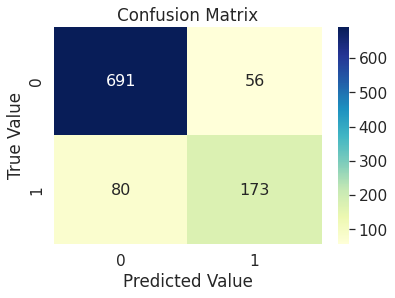

In [29]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
def plot_cm(conf_matrix):
  sns.set(font_scale=1.4,color_codes=True,palette="deep")
  sns.heatmap(cm,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
plot_cm(cm)